In [ ]:
import d2l
import torch
from sympy.physics.control.control_plots import matplotlib
from torch import nn
import torch.nn.functional as F
import torchvision

In [ ]:
class BCE_IoU_Loss(nn.Module):
    """
    损失函数 L_total = L_BCE + L_IoU
    """
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth  # 平滑项

    def forward(self, preds, targets):
        # BCE损失
        bce_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')

        # IoU损失
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        union = (preds + targets).sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        iou_loss = 1 - iou

        # 组合损失
        total_loss = bce_loss.mean() + iou_loss.mean()
        return total_loss

In [ ]:
# 获得编码器的预训练版本
import clip

device = "mps" if torch.mps.is_available() else "cpu"
pretrained_encoder, preprocess = clip.load("ViT-B/32", device=device)

print(pretrained_encoder)

In [ ]:
import os
import torch
from pycocotools.coco import COCO
from PIL import Image

image = preprocess(Image.open("../cocoseg/train2017/000000000009.jpg")).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = pretrained_encoder.encode_image(image)

image_features.shape

In [ ]:
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class CocoSegDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        Args:
            root_dir (str): 根目录（包含 train2017/val2017）
            ann_file (str): COCO标注文件路径
            transform (callable, optional): 数据增强变换
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)

        # 获取所有有效的图像ID
        self.img_ids = self.coco.getImgIds()

        # 加载类别信息
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.cat_ids = self.coco.getCatIds()
        self.cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(self.cat_ids)}
        self.cat_names = [cat['name'] for cat in self.categories]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 获取图像ID和信息
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # 加载图像
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        orig_size = image.size

        # 加载标注
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # 创建掩码和标签
        masks = []
        labels = []
        for ann in anns:
            mask = self.coco.annToMask(ann)
            cat_idx = self.cat_id_to_idx[ann['category_id']]
            masks.append(mask)
            labels.append(cat_idx)

        # 确保至少有一个实例
        if not masks:
            masks = [np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)]
            labels = [0]

        # 转换为numpy数组
        masks = np.stack(masks, axis=0)
        labels = np.array(labels, dtype=np.int64)

        # 数据转换
        if self.transform is not None:
            image = self.transform(image)
            masks = torch.from_numpy(masks)
            if image.shape[-2:] != masks.shape[-2:]:
                masks = F.interpolate(
                    masks.unsqueeze(0).float(),
                    size=image.shape[-2:],
                    mode='nearest'
                ).squeeze(0)
        else:
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
            masks = torch.from_numpy(masks)

        labels = torch.from_numpy(labels)

        return {
            'image': image,
            'mask': masks,
            'label': labels,
            'img_id': img_id,
            'orig_size': orig_size
        }

    def get_cat_name(self, cat_idx):
        return self.cat_names[cat_idx]

    def __repr__(self):
        return f"CocoSegDataset(num_images={len(self)}, num_categories={len(self.cat_ids)})"


# 创建数据集实例
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CocoSegDataset(
    root_dir="../cocoseg/train2017",
    ann_file="../cocoseg/annotations/instances_train2017.json",
    transform=transform
)

val_dataset = CocoSegDataset(
    root_dir="../cocoseg/val2017",
    ann_file="../cocoseg/annotations/instances_val2017.json",
    transform=transform
)

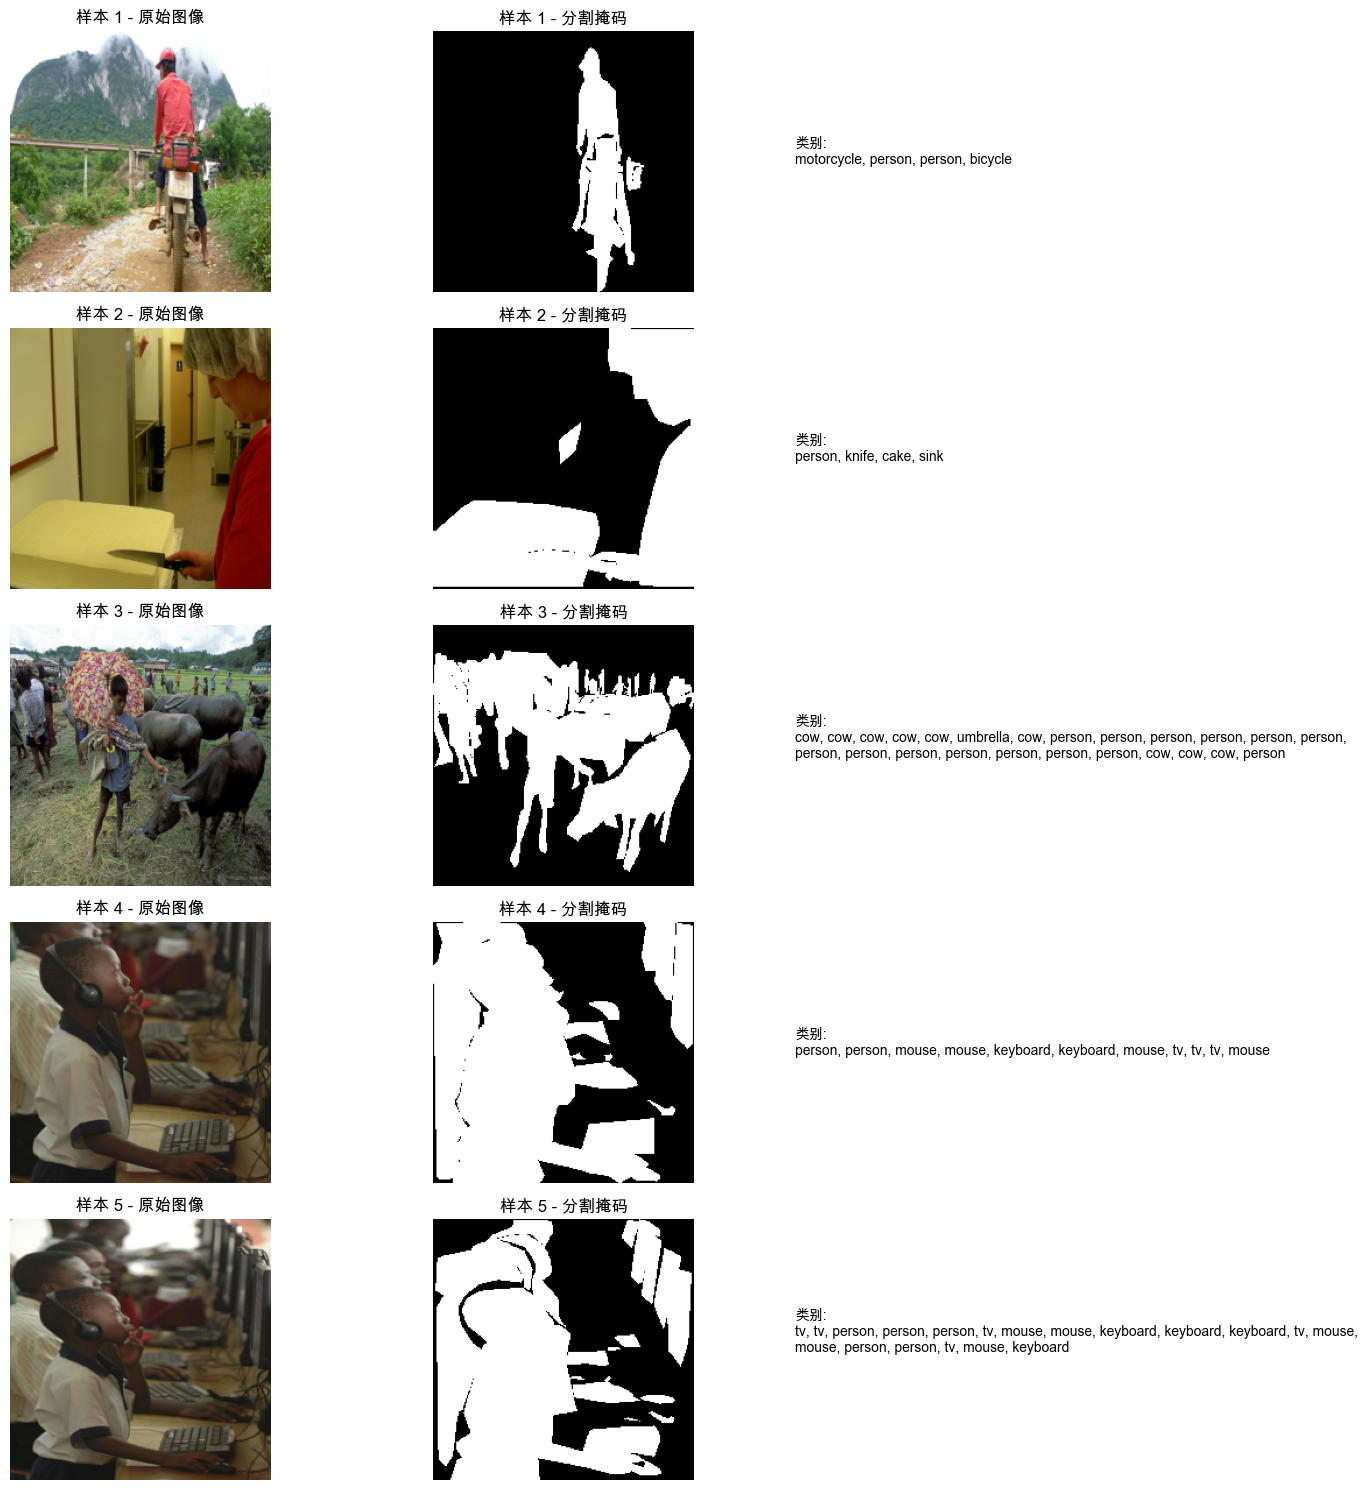

In [33]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = ['Arial Unicode MS']

# 创建可视化函数
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    
    for i in range(num_samples):
        sample = dataset[i]
        
        # 获取数据
        image = sample['image']
        masks = sample['mask']
        labels = sample['label']
        
        # 反归一化图像
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        
        # 转换为numpy格式用于显示
        image = image.permute(1, 2, 0).numpy()
        combined_mask = torch.any(masks > 0.5, dim=0).float().numpy()
        
        # 获取类别名称
        label_names = [dataset.get_cat_name(label.item()) for label in labels]
        
        # 绘制图像
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title(f'样本 {i+1} - 原始图像')
        plt.axis('off')
        
        # 绘制掩码
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(combined_mask, cmap='gray')
        plt.title(f'样本 {i+1} - 分割掩码')
        plt.axis('off')
        
        # 显示类别信息
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.text(0.1, 0.5, f'类别:\n{", ".join(label_names)}', 
                fontsize=10, wrap=True)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化训练集的前5个样本
visualize_samples(train_dataset)

In [11]:
class FPNlikeDecoder(nn.Module):
    def __init__(self,
                 in_channels_list,   # 编码器各层输出通道列表 e.g. [256, 512, 1024]
                 num_upsample_layers=4,  # 上采样层级数
                 final_channels=1):   # 最终输出通道数（通常为1）
        super().__init__()

        # 特征融合部分：直接求和所有中间层特征
        self.total_in_channels = sum(in_channels_list)

        # 自适应通道调整模块（可选）
        self.adaptive_weighting = nn.Sequential(
            nn.Conv2d(self.total_in_channels, self.total_in_channels//4, 1),
            nn.GELU(),
            nn.Conv2d(self.total_in_channels//4, self.total_in_channels, 1)
        )

        # 构建上采样器：每个层级包含3x3卷积+双线性上采样
        self.upstream = nn.ModuleList()
        current_channels = self.total_in_channels
        for _ in range(num_upsample_layers):
            self.upstream.append(
                nn.Sequential(
                    nn.Conv2d(current_channels, current_channels//2, 3, padding=1),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                )
            )
            current_channels = current_channels // 2

        # 最终预测层
        self.predictor = nn.Conv2d(current_channels, final_channels, 1)

    def forward(self, features):
        # features: list of [B, C_i, H, W] from encoder layers
        # 特征求和与自适应加权
        fused = torch.sum(features, dim=0)  # [B, total_in_channels, H, W]
        if hasattr(self, 'adaptive_weighting'):
            fused = self.adaptive_weighting(fused)

        # 逐级上采样
        for up in self.upstream:
            fused = up(fused)

        # 生成最终预测
        mask = self.predictor(fused)  # [B, 1, H_up, W_up]
        return mask

# 使用示例
if __name__ == "__main__":
    # 假设ViT编码器输出三个特征层：[256, 512, 1024]
    decoder = FPNlikeDecoder(
        in_channels_list=[256, 512, 1024],
        num_upsample_layers=4,  # 4次上采样 → 空间放大16倍
        final_channels=1
    )

    # 模拟输入特征（batch_size=2，假设原图尺寸256x256）
    features = [
        torch.randn(2, 256, 64, 64),   # 最深层特征（H/W=1/4）
        torch.randn(2, 512, 128, 128),
        torch.randn(2, 1024, 256, 256)
    ]

    # 前向传播
    mask_pred = decoder(features)
    print(mask_pred.shape)  # 输出：[2, 1, 1024, 1024]